<a href="https://colab.research.google.com/github/iaramer/stock_analysis/blob/data_scrapping/Stock_analysis_data_scrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json

import numpy as np
import pandas as pd
import missingno as msno

from pandas_datareader import data

# Reading data from external sources
import urllib as u
from urllib.request import urlopen

# Graphics
from tqdm import tqdm

API_URL = 'https://financialmodelingprep.com/api/v3/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.DataFrame()

# Additional functions

We will also need a few helper functions in order to streamline the code:

* get_json_data: used to scrape the links to financialmodelingprep API, and to pull the financial data.

* get_price_var: used to compute the price variation during 2019, leverages pandas_datareader and Yahoo Finance.

* find_in_json: used to scan a complex json file for a key and return its value.

In [0]:
def get_json_data(url):
    '''
    Scrape data (which must be json format) from given url
    Input: url to financialmodelingprep API
    Output: json file
    '''
    response = urlopen(url)
    dat = response.read().decode('utf-8')
    return json.loads(dat)

def find_in_json(obj, key):
    '''
    Scan the json file to find the value of the required key.
    Input: json file
           required key
    Output: value corresponding to the required key
    '''
    # Initialize output as empty
    arr = []

    def extract(obj, arr, key):
        '''
        Recursively search for values of key in json file.
        '''
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

## Get S&P500 stock list

In [0]:
import bs4 as bs
import pickle
import requests
import lxml

def save_sp500_tickers():
  resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')        
  soup = bs.BeautifulSoup(resp.text,'lxml')        
  table = soup.find('table', {'class': 'wikitable sortable'})        

  tickers = []

  for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

  with open("sp500tickers.pickle", "wb") as f:
    pickle.dump(tickers, f)

  result = []  
  for ticker in tickers:
    if ticker.endswith('\n'):
      result.append(ticker.replace('\n', ''))

  return result

In [0]:
sp500_tickers = save_sp500_tickers()

df['ticker'] = sp500_tickers

## Get ticker and sector

In [0]:
tickers_sector = dict()
for tick in tqdm(sp500_tickers):
  url = API_URL + 'company/profile/' + tick # get sector from here
  tick_company_data = get_json_data(url)
  sector = find_in_json(tick_company_data, 'sector').pop()
  tickers_sector[tick] = sector

100%|██████████| 505/505 [02:25<00:00,  3.48it/s]


In [0]:
ticker_sector_df = pd.DataFrame(tickers_sector.items(), columns=['ticker', 'sector'])

In [0]:
sectors = ticker_sector_df['sector'].unique()
sectors

array(['Industrials', 'Healthcare', 'Technology', 'Consumer Cyclical',
       'Utilities', 'Financial Services', 'Basic Materials',
       'Real Estate', 'Consumer Defensive', 'Communication Services',
       'Energy', None], dtype=object)

## Get companies Financial Statements

In [0]:
def get_financial_statements(url, tickers):
  '''
  Scrape data (which must be json format) from given url
  Input: url with pattern 'https://financialmodelingprep.com/api/v3/financials/' to financialmodelingprep API
  Output: financial data column names and financial data
  '''
  
  # Column names
  first_ticker_url = url + tickers[0] # we only need solumn names, no metter which ticker
  column_names = get_json_data(first_ticker_url)
  financial_column_names = ['ticker'] + list(column_names['financials'][0].keys())

  # Financial data
  financial_statements = []
  skipped_tickers = []
  for tick in tqdm(tickers):
    tick_financial_data = get_json_data(url + tick)

    if 'financials' not in tick_financial_data:
      skipped_tickers.append(tick)
      continue

    for financial_statement in tick_financial_data['financials']:
      financial_statement_values = [tick] + list(financial_statement.values())
      financial_statements.append(financial_statement_values)

    financial_data = np.array(financial_statements)

  print('\n\n Skipped tickers: ' + str(skipped_tickers))

  return financial_column_names, financial_data

### Income Statement

In [0]:
income_statement_url = API_URL + 'financials/income-statement/'
tickers = list(ticker_sector_df['ticker'])

income_statement_cols, income_statement_data = get_financial_statements(income_statement_url, tickers)

100%|██████████| 505/505 [02:22<00:00,  3.53it/s]



 Skipped tickers: ['CARR', 'OTIS']


In [0]:
income_statement_df = pd.DataFrame(income_statement_data, columns=income_statement_cols)
income_statement_df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin
0,MMM,2019-12-31,32136000000.0,-0.0191973142072,17136000000.0,15000000000.0,1911000000.0,7029000000.0,8940000000.0,6174000000.0,448000000.0,5712000000.0,1130000000.0,0.0,0.0,4570000000.0,0.0,4570000000.0,7.92,7.81,577000000.0,585100000.0,5.66740728081,0.466766243465,0.241691560866,0.19212098581,0.142208115509,0.16713343291,7767000000.0,6174000000.0,4570000000.0,0.177744585512,0.142208115509
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198
3,MMM,2016-12-31,30109000000.0,-0.00545022131202,15040000000.0,15069000000.0,1735000000.0,6111000000.0,8045000000.0,7223000000.0,199000000.0,7053000000.0,1995000000.0,0.0,0.0,5050000000.0,0.0,5050000000.0,8.35,8.16,604700000.0,618700000.0,4.32843058025,0.50048158358,0.288850509814,0.239895047992,0.167723936365,0.174100767212,8697000000.0,7223000000.0,5050000000.0,0.234248895679,0.167723936365
4,MMM,2015-12-31,30274000000.0,-0.0486156940385,15383000000.0,14891000000.0,1763000000.0,6182000000.0,8094000000.0,6946000000.0,149000000.0,6823000000.0,1982000000.0,0.0,0.0,4833000000.0,0.0,4833000000.0,7.72,7.58,625600000.0,637200000.0,4.01914626491,0.491874215498,0.276838211006,0.229437801414,0.159641936976,0.163803924159,8381000000.0,6946000000.0,4833000000.0,0.225374909163,0.159641936976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5409,ZTS,2013-12-31,4561000000.0,0.0518911439114,1669000000.0,2892000000.0,399000000.0,1613000000.0,2012000000.0,690000000.0,113000000.0,690000000.0,187000000.0,0.0,0.0,504000000.0,0.0,504000000.0,1.01,1.01,500002000.0,500317000.0,0.0,0.634071475554,0.197105897829,0.151282613462,0.110502082877,0.108967331725,899000000.0,690000000.0,504000000.0,0.151282613462,0.110502082877
5410,ZTS,2012-12-31,4336000000.0,0.0243326246161,1563000000.0,2773000000.0,409000000.0,1470000000.0,2032000000.0,741000000.0,31000000.0,710000000.0,274000000.0,0.0,0.0,436000000.0,0.0,436000000.0,0.87,0.87,500000000.0,500000000.0,0.0,0.6395,0.217,0.1709,0.101,0.0756,941000000.0,741000000.0,436000000.0,0.1637,0.1006
5411,ZTS,2011-12-31,4233000000.0,0.181742043551,1652000000.0,2581000000.0,427000000.0,1453000000.0,2151000000.0,430000000.0,36000000.0,391000000.0,146000000.0,3000000.0,0.0,245000000.0,0.0,245000000.0,0.49,0.49,500000000.0,500000000.0,0.0,0.6097,0.149,0.1009,0.058,0.0855,632000000.0,427000000.0,248000000.0,0.0924,0.0579
5412,ZTS,2010-12-31,3582000000.0,0.297826086957,1444000000.0,2138000000.0,411000000.0,1382000000.0,1960000000.0,178000000.0,0.0,177000000.0,67000000.0,1000000.0,0.0,110000000.0,0.0,110000000.0,0.22,0.22,,500000000.0,0.0,0.5969,0.101,0.0494,0.031,0.0363,362000000.0,177000000.0,111000000.0,0.0494,0.0307


### Balance Sheet Statement

In [0]:
balance_sheet_statement_url = API_URL + 'financials/balance-sheet-statement/'
tickers = list(ticker_sector_df['ticker'])

balance_sheet_statement_cols, balance_sheet_statement_data = get_financial_statements(balance_sheet_statement_url, tickers)

100%|██████████| 505/505 [02:23<00:00,  3.53it/s]



 Skipped tickers: ['CARR', 'OTIS']


In [0]:
balance_sheet_statement_df = pd.DataFrame(balance_sheet_statement_data, columns=balance_sheet_statement_cols)
balance_sheet_statement_df

,ticker,date,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities
0,MMM,2019-12-31,0.0,98000000.0,98000000.0,4791000000.0,4134000000.0,12971000000.0,9333000000.0,19823000000.0,0.0,0.0,31688000000.0,44659000000.0,2228000000.0,247000000.0,9222000000.0,17518000000.0,17765000000.0,0.0,194000000.0,0.0,20793000000.0,34596000000.0,0.0,42135000000.0,10063000000.0,98000000.0,17765000000.0,0.0,4581000000.0
1,MMM,2018-12-31,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,12708000000.0,0.0,0.0,22791000000.0,36500000000.0,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0
2,MMM,2017-12-31,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,13449000000.0,0.0,0.0,23710000000.0,37987000000.0,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,0.0,39115000000.0,11563000000.0,1076000000.0,10896000000.0,0.0,3679000000.0
3,MMM,2016-12-31,2398000000.0,280000000.0,2678000000.0,4392000000.0,3385000000.0,11726000000.0,8516000000.0,11486000000.0,17000000.0,0.0,21180000000.0,32906000000.0,1798000000.0,972000000.0,6219000000.0,10678000000.0,11650000000.0,0.0,299000000.0,0.0,12326000000.0,22608000000.0,0.0,37907000000.0,10298000000.0,297000000.0,9252000000.0,0.0,4063000000.0
4,MMM,2015-12-31,1798000000.0,118000000.0,1916000000.0,4154000000.0,3518000000.0,10986000000.0,8515000000.0,11850000000.0,117000000.0,0.0,21732000000.0,32718000000.0,1694000000.0,2044000000.0,7118000000.0,8753000000.0,10797000000.0,0.0,332000000.0,0.0,10333000000.0,21010000000.0,0.0,36575000000.0,11708000000.0,235000000.0,8999000000.0,0.0,3559000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,ZTS,2014-12-31,882000000.0,109000000.0,882000000.0,980000000.0,1289000000.0,3465000000.0,1318000000.0,1703000000.0,0.0,54000000.0,3142000000.0,6607000000.0,290000000.0,7000000.0,1086000000.0,3643000000.0,3650000000.0,0.0,26000000.0,0.0,4127000000.0,5296000000.0,958000000,709000000.0,1311000000.0,109000000.0,2768000000.0,0.0,83000000.0
5374,ZTS,2013-12-31,610000000.0,97000000.0,610000000.0,1138000000.0,1293000000.0,3357000000.0,1295000000.0,1785000000.0,0.0,63000000.0,3201000000.0,6558000000.0,506000000.0,15000000.0,1415000000.0,3642000000.0,3657000000.0,0.0,40000000.0,0.0,4132000000.0,5618000000.0,878000000,276000000.0,940000000.0,97000000.0,3047000000.0,0.0,71000000.0
5375,ZTS,2012-12-31,317000000.0,0.0,317000000.0,900000000.0,1345000000.0,2864000000.0,1241000000.0,1853000000.0,0.0,317000000.0,3398000000.0,6262000000.0,319000000.0,73000000.0,1123000000.0,509000000.0,582000000.0,0.0,512000000.0,0.0,1098000000.0,2221000000.0,-157000000.0,0.0,4026000000.0,0.0,265000000.0,302000000.0,731000000.0
5376,ZTS,2011-12-31,79000000.0,0.0,79000000.0,871000000.0,1063000000.0,2311000000.0,1243000000.0,1917000000.0,0.0,239000000.0,3400000000.0,5711000000.0,214000000.0,0.0,843000000.0,575000000.0,575000000.0,0.0,451000000.0,0.0,1132000000.0,1975000000.0,-65000000.0,,3720000000.0,0.0,496000000.0,298000000.0,629000000.0


### Cash Flow Statement

In [0]:
cash_flow_statement_url = API_URL + 'financials/cash-flow-statement/'
tickers = list(ticker_sector_df['ticker'])

cash_flow_statement_cols, cash_flow_statement_data = get_financial_statements(cash_flow_statement_url, tickers)

100%|██████████| 505/505 [02:19<00:00,  3.63it/s]



 Skipped tickers: ['CARR', 'OTIS']


In [0]:
cash_flow_statement_df = pd.DataFrame(cash_flow_statement_data, columns=cash_flow_statement_cols)
cash_flow_statement_df

,ticker,date,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap
0,MMM,2019-12-31,1593000000.0,278000000.0,7070000000.0,1699000000.0,-4984000000.0,-3042000000.0,-6444000000.0,-2400000000.0,-1407000000.0,-3316000000.0,-1124000000.0,-2000000.0,-500000000.0,5371000000.0,0.0
1,MMM,2018-12-31,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0
2,MMM,2017-12-31,1544000000.0,324000000.0,6240000000.0,1373000000.0,-2023000000.0,-4220000000.0,-3086000000.0,-1540000000.0,-2068000000.0,-2803000000.0,-2655000000.0,156000000.0,655000000.0,4867000000.0,0.0
3,MMM,2016-12-31,1474000000.0,298000000.0,6662000000.0,1420000000.0,-16000000.0,-5163000000.0,-1403000000.0,-195000000.0,-3753000000.0,-2678000000.0,-4626000000.0,-33000000.0,600000000.0,5242000000.0,0.0
4,MMM,2015-12-31,1435000000.0,276000000.0,6420000000.0,1461000000.0,-2914000000.0,-3938000000.0,-2817000000.0,-5082000000.0,-5238000000.0,-2561000000.0,-3648000000.0,-54000000.0,-99000000.0,4959000000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5413,ZTS,2013-12-31,209000000.0,43000000.0,681000000.0,184000000.0,-4000000.0,0.0,-188000000.0,-0.0,-610000000.0,-0.0,-200000000.0,-9000000.0,293000000.0,497000000.0,0.0
5414,ZTS,2012-12-31,200000000.0,28000000.0,454000000.0,-126000000.0,3000000.0,0.0,-135000000.0,0.0,0.0,-63000000.0,-78000000.0,-3000000.0,238000000.0,328000000.0,-0.0171
5415,ZTS,2011-12-31,205000000.0,19000000.0,497000000.0,-135000000.0,-311000000.0,0.0,-449000000.0,-143000000.0,0.0,-416000000.0,-30000000.0,-2000000.0,16000000.0,362000000.0,-0.0171
5416,ZTS,2010-12-31,185000000.0,16000000.0,254000000.0,-124000000.0,122000000.0,0.0,-9000000.0,0.0,0.0,-207000000.0,-277000000.0,-4000000.0,-36000000.0,130000000.0,-0.0171


### Concatenate financial statement data

In [0]:
financial_statement_df = pd.DataFrame()
financial_statement_df = pd.merge(income_statement_df, balance_sheet_statement_df, 'outer', on=['ticker', 'date'])
financial_statement_df = pd.merge(financial_statement_df, cash_flow_statement_df, 'outer', on=['ticker', 'date'])

financial_statement_df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap
0,MMM,2019-12-31,32136000000.0,-0.0191973142072,17136000000.0,15000000000.0,1911000000.0,7029000000.0,8940000000.0,6174000000.0,448000000.0,5712000000.0,1130000000.0,0.0,0.0,4570000000.0,0.0,4570000000.0,7.92,7.81,577000000.0,585100000.0,5.66740728081,0.466766243465,0.241691560866,0.19212098581,0.142208115509,0.16713343291,7767000000.0,6174000000.0,4570000000.0,0.177744585512,0.142208115509,0.0,98000000.0,98000000.0,4791000000.0,4134000000.0,12971000000.0,9333000000.0,19823000000.0,0.0,0.0,31688000000.0,44659000000.0,2228000000.0,247000000.0,9222000000.0,17518000000.0,17765000000.0,0.0,194000000.0,0.0,20793000000.0,34596000000.0,0.0,42135000000.0,10063000000.0,98000000.0,17765000000.0,0.0,4581000000.0,1593000000.0,278000000.0,7070000000.0,1699000000.0,-4984000000.0,-3042000000.0,-6444000000.0,-2400000000.0,-1407000000.0,-3316000000.0,-1124000000.0,-2000000.0,-500000000.0,5371000000.0,0.0
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,12708000000.0,0.0,0.0,22791000000.0,36500000000.0,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,13449000000.0,0.0,0.0,23710000000.0,37987000000.0,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,0.0,39115000000.0,11563000000.0,1076000000.0,10896000000.0,0.0,367

In [0]:
ticker_sector_df

financial_statement_df = pd.merge(financial_statement_df, ticker_sector_df, 'outer', on='ticker')

financial_statement_df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,Tax assets,Total non-current assets,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,sector
0,MMM,2019-12-31,32136000000.0,-0.0191973142072,17136000000.0,15000000000.0,1911000000.0,7029000000.0,8940000000.0,6174000000.0,448000000.0,5712000000.0,1130000000.0,0.0,0.0,4570000000.0,0.0,4570000000.0,7.92,7.81,577000000.0,585100000.0,5.66740728081,0.466766243465,0.241691560866,0.19212098581,0.142208115509,0.16713343291,7767000000.0,6174000000.0,4570000000.0,0.177744585512,0.142208115509,0.0,98000000.0,98000000.0,4791000000.0,4134000000.0,12971000000.0,9333000000.0,19823000000.0,0.0,0.0,31688000000.0,44659000000.0,2228000000.0,247000000.0,9222000000.0,17518000000.0,17765000000.0,0.0,194000000.0,0.0,20793000000.0,34596000000.0,0.0,42135000000.0,10063000000.0,98000000.0,17765000000.0,0.0,4581000000.0,1593000000.0,278000000.0,7070000000.0,1699000000.0,-4984000000.0,-3042000000.0,-6444000000.0,-2400000000.0,-1407000000.0,-3316000000.0,-1124000000.0,-2000000.0,-500000000.0,5371000000.0,0.0,Industrials
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,12708000000.0,0.0,0.0,22791000000.0,36500000000.0,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0,Industrials
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,13449000000.0,0.0,0.0,23710000000.0,37987000000.0,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,0.0,39115000000.0,11563000000.0,107

### Missing values

In [0]:
print(financial_statement_df.isnull().sum())

ticker                              0
date                                2
Revenue                             7
Revenue Growth                      7
Cost of Revenue                     7
                                   ..
Effect of forex changes on cash     3
Net cash flow / Change in cash      3
Free Cash Flow                      3
Net Cash/Marketcap                  3
sector                             52
Length: 78, dtype: int64


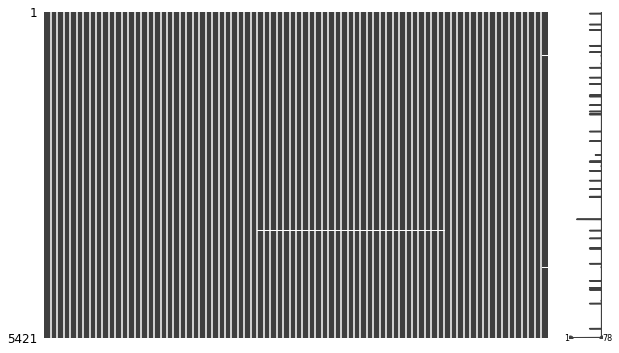

In [0]:
msno.matrix(financial_statement_df, figsize=(10, 6), fontsize=10);

Remove NaN values from dataset

In [0]:
number_before_removing = financial_statement_df.shape[0]
print('Number of rows before removing: ' + str(number_before_removing))

financial_statement_df.dropna(inplace=True)

number_after_removing = financial_statement_df.shape[0]
print('Number of rows after removing: ' + str(number_after_removing))
print(str(number_before_removing - number_after_removing) + ' rows were removed as NaN values')

Number of rows before removing: 5421
Number of rows after removing: 5327
94 rows were removed as NaN values


## Get enterprise value

In [0]:
def get_financial_data(url, data_name, tickers):
  '''
  Scrape data (which must be json format) from given url
  Input: url with pattern 'https://financialmodelingprep.com/api/v3/financials/' to financialmodelingprep API
  Output: financial data column names and financial data
  '''
  
  # Column names
  first_ticker_url = url + tickers[0] # we only need solumn names, no metter which ticker
  column_names = get_json_data(first_ticker_url)
  financial_column_names = ['ticker'] + list(column_names[data_name][0].keys())

  # Financial data
  financial_statements = []
  skipped_tickers = []
  for tick in tqdm(tickers):
    tick_financial_data = get_json_data(url + tick)

    if data_name not in tick_financial_data:
      skipped_tickers.append(tick)
      continue

    for financial_statement in tick_financial_data[data_name]:
      financial_statement_values = [tick] + list(financial_statement.values())
      financial_statements.append(financial_statement_values)

    financial_data = np.array(financial_statements)

  print('\n\n Skipped tickers: ' + str(skipped_tickers))

  return financial_column_names, financial_data

In [0]:
enterprise_value_url = API_URL + 'enterprise-value/'
tickers = list(ticker_sector_df['ticker'])

enterprise_value_cols, enterprise_value_data = get_financial_data(enterprise_value_url, 'enterpriseValues', tickers)

100%|██████████| 505/505 [02:20<00:00,  3.59it/s]



 Skipped tickers: ['BRK.B', 'BF.B', 'CARR', 'HWM', 'NLOK', 'OTIS']


In [0]:
enterprise_value_df = pd.DataFrame(enterprise_value_data, columns=enterprise_value_cols)
enterprise_value_df['Stock Price'] = enterprise_value_df['Stock Price'].astype(np.float64)
enterprise_value_df

,ticker,date,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value
0,MMM,2019-12-31,162.51,5.77E8,93768270000.0,0.0,17765000000.0,111533270000.0
1,MMM,2018-12-31,199.27,5.885E8,117270395000.0,2853000000.0,14622000000.0,129039395000.0
2,MMM,2017-12-31,251.54,5.975E8,150295150000.0,3053000000.0,13949000000.0,161191150000.0
3,MMM,2016-12-31,175.42,6.047E8,106076474000.0,2398000000.0,11650000000.0,115328474000.0
4,MMM,2015-12-31,151.00,6.256E8,94465600000.0,1798000000.0,10797000000.0,103464600000.0
...,...,...,...,...,...,...,...,...
5232,ZTS,2017-12-31,78.35,4.89918E8,38385075300.0,1564000000.0,4997000000.0,41818075300.0
5233,ZTS,2016-12-31,54.27,4.95715E8,26902453050.0,727000000.0,4468000000.0,30643453050.0
5234,ZTS,2015-12-31,43.05,4.99707E8,21512386350.0,1154000000.0,4468000000.0,24826386350.0
5235,ZTS,2014-12-31,42.73,5.01055E8,21410080150.0,882000000.0,3650000000.0,24178080150.0


### Add 'next year price'

In [0]:
enterprise_value_df['next year upside'] = enterprise_value_df['Stock Price']

tickers = list(ticker_sector_df['ticker'])
for ticker in tickers:
  ticker_df = enterprise_value_df[enterprise_value_df['ticker'] == ticker]
  vals = ticker_df.values
  for i, row in enumerate(vals):
    if i < len(vals) - 1:
      vals[i+1][8] = (row[2] - vals[i+1][2])/vals[i+1][2]
    if i == 0:
      vals[i][8] = np.nan
  enterprise_value_df[enterprise_value_df['ticker'] == ticker] = vals

enterprise_value_df

,ticker,date,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,next year upside
0,MMM,2019-12-31,162.51,5.77E8,93768270000.0,0.0,17765000000.0,111533270000.0,NaN
1,MMM,2018-12-31,199.27,5.885E8,117270395000.0,2853000000.0,14622000000.0,129039395000.0,-0.184473
2,MMM,2017-12-31,251.54,5.975E8,150295150000.0,3053000000.0,13949000000.0,161191150000.0,-0.207800
3,MMM,2016-12-31,175.42,6.047E8,106076474000.0,2398000000.0,11650000000.0,115328474000.0,0.433930
4,MMM,2015-12-31,151.00,6.256E8,94465600000.0,1798000000.0,10797000000.0,103464600000.0,0.161722
...,...,...,...,...,...,...,...,...,...
5232,ZTS,2017-12-31,78.35,4.89918E8,38385075300.0,1564000000.0,4997000000.0,41818075300.0,0.086024
5233,ZTS,2016-12-31,54.27,4.95715E8,26902453050.0,727000000.0,4468000000.0,30643453050.0,0.443707
5234,ZTS,2015-12-31,43.05,4.99707E8,21512386350.0,1154000000.0,4468000000.0,24826386350.0,0.260627
5235,ZTS,2014-12-31,42.73,5.01055E8,21410080150.0,882000000.0,3650000000.0,24178080150.0,0.007489


### Concatenate with financial statement data

In [0]:
financial_statement_df = pd.merge(financial_statement_df, enterprise_value_df, 'outer', on=['ticker', 'date'])
financial_statement_df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",...,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,sector,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,next year upside
0,MMM,2019-12-31,32136000000.0,-0.0191973142072,17136000000.0,15000000000.0,1911000000.0,7029000000.0,8940000000.0,6174000000.0,448000000.0,5712000000.0,1130000000.0,0.0,0.0,4570000000.0,0.0,4570000000.0,7.92,7.81,577000000.0,585100000.0,5.66740728081,0.466766243465,0.241691560866,0.19212098581,0.142208115509,0.16713343291,7767000000.0,6174000000.0,4570000000.0,0.177744585512,0.142208115509,0.0,98000000.0,98000000.0,4791000000.0,4134000000.0,12971000000.0,9333000000.0,...,2228000000.0,247000000.0,9222000000.0,17518000000.0,17765000000.0,0.0,194000000.0,0.0,20793000000.0,34596000000.0,0.0,42135000000.0,10063000000.0,98000000.0,17765000000.0,0.0,4581000000.0,1593000000.0,278000000.0,7070000000.0,1699000000.0,-4984000000.0,-3042000000.0,-6444000000.0,-2400000000.0,-1407000000.0,-3316000000.0,-1124000000.0,-2000000.0,-500000000.0,5371000000.0,0.0,Industrials,162.51,5.77E8,93768270000.0,0.0,17765000000.0,111533270000.0,NaN
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,...,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0,Industrials,199.27,5.885E8,117270395000.0,2853000000.0,14622000000.0,129039395000.0,-0.184473
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,...,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,

### Missing values

In [0]:
print(financial_statement_df.isnull().sum())

ticker                         0
date                           0
Revenue                       43
Revenue Growth                43
Cost of Revenue               43
                            ... 
Market Capitalization        133
- Cash & Cash Equivalents    133
+ Total Debt                 133
Enterprise Value             133
next year upside             632
Length: 85, dtype: int64


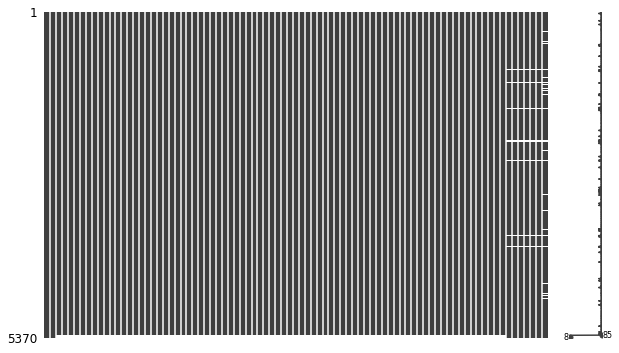

In [0]:
msno.matrix(financial_statement_df, figsize=(10, 6), fontsize=10);

Remove NaN values from dataset

In [0]:
number_before_removing = financial_statement_df.shape[0]
print('Number of rows before removing: ' + str(number_before_removing))

financial_statement_df.dropna(inplace=True)

number_after_removing = financial_statement_df.shape[0]
print('Number of rows after removing: ' + str(number_after_removing))
print(str(number_before_removing - number_after_removing) + ' rows were removed as NaN values')

Number of rows before removing: 5370
Number of rows after removing: 4698
672 rows were removed as NaN values


In [0]:
financial_statement_df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",...,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,sector,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,next year upside
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,...,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0,Industrials,199.27,5.885E8,117270395000.0,2853000000.0,14622000000.0,129039395000.0,-0.184473
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,...,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,0.0,39115000000.0,11563000000.0,1076000000.0,10896000000.0,0.0,3679000000.0,1544000000.0,324000000.0,6240000000.0,1373000000.0,-2023000000.0,-4220000000.0,-3086000000.0,-1540000000.0,-2068000000.0,-2803000000.0,-2655000000.0,156000000.0,655000000.0,4867000000.0,0.0,Industrials,251.54,5.975E8,150295150000.0,3053000000.0,13949000000.0,161191150000.0,-0.207800
3,MMM,2016-12-31,30109000000.0,-0.00545022131202,15040000000.0,15069000000.0,1735000000.0,6111000000.0,8045000000.0,7223000000.0,199000000.0,7053000000.0,1995000000.0,0.0,0.0,5050000000.0,0.0,5050000000.0,8.35,8.16,604700000.0,618700000.0,4.32843058025,0.50048158358,0.288850509814,0.239895047992,0.167723936365,0.174100767212,8697000000.0,7223000000.0,5050000000.0,0.234248895679,0.167723936365,2398000000.0,280000000.0,2678000000.0,4392000000.0,3385000000.0,11726000000.0,8516000000.0,...,1798000000.0,972000000.0,6219000000.0,10678000000.0,11650000000.0,0.0,299000000.0

# Save data as CSV

In [0]:
# financial_statement_df.to_csv('financial_statement.csv', index=False)
# financial_statement_df.to_csv('financial_statement.csv')

In [0]:
# from google.colab import files
# files.download('financial_statement.csv')

# For price extraction

In [0]:
def get_price_var(symbol):
    '''
    Get historical price data for a given symbol leveraging the power of pandas_datareader and Yahoo.
    Compute the difference between first and last available time-steps in terms of Adjusted Close price..
    Input: ticker symbol
    Output: price variation 
    '''
    # read data
    prices = data.DataReader(symbol, 'yahoo', '2019-01-01', '2019-12-31')['Adj Close']

    # get all timestamps for specific lookups
    today = prices.index[-1]
    start = prices.index[0]

    # calculate percentage price variation
    price_var = ((prices[today] - prices[start]) / prices[start]) * 100
    return price_var



# read data
prices = data.DataReader('AAPL', 'yahoo', '2019-01-01', '2019-12-31')['Adj Close']

# get all timestamps for specific lookups
today = prices.index[-1]
print(today)
print(prices[today])
start = prices.index[0]
print(start)
print(prices[start])

# calculate percentage price variation
price_var = ((prices[today] - prices[start]) / prices[start]) * 100
print(price_var)
price_var = ((prices[start] - prices[today]) / prices[today]) * 100
print(str(price_var) + ' %')

2019-12-31 00:00:00
292.163818359375
2019-01-02 00:00:00
154.79498291015625
88.74243393853939
-47.017743750955745 %


# Fast learn

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# from pandas_profiling import ProfileReport
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, roc_auc_score, f1_score, make_scorer, plot_confusion_matrix, roc_curve, precision_recall_curve, average_precision_score

# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from tabulate import tabulate

# ignore FutureWarnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')

RANDOM_SEED = 57

# from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression
from datetime import datetime
from tabulate import tabulate

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Finalize data

In [0]:
df = financial_statement_df.replace('', np.nan)
df

,ticker,date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",...,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,sector,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,next year upside
1,MMM,2018-12-31,32765000000.0,0.035000157943,16682000000.0,16083000000.0,1821000000.0,7602000000.0,9423000000.0,7207000000.0,350000000.0,7000000000.0,1637000000.0,0.0,0.0,5349000000.0,0.0,5349000000.0,9.09,8.89,588500000.0,602000000.0,5.30398671096,0.490859148482,0.265374637571,0.219960323516,0.163253471692,0.148390050359,8695000000.0,7207000000.0,5349000000.0,0.21364260644,0.163253471692,2853000000.0,380000000.0,3233000000.0,5020000000.0,4366000000.0,13709000000.0,8738000000.0,...,2266000000.0,1211000000.0,7244000000.0,13411000000.0,14622000000.0,0.0,243000000.0,0.0,16421000000.0,26704000000.0,0.0,40636000000.0,9796000000.0,380000000.0,11769000000.0,0.0,3039000000.0,1488000000.0,302000000.0,6439000000.0,1577000000.0,13000000.0,-6698000000.0,222000000.0,-750000000.0,-4870000000.0,-3193000000.0,-6701000000.0,-160000000.0,-200000000.0,4862000000.0,0.0,Industrials,199.27,5.885E8,117270395000.0,2853000000.0,14622000000.0,129039395000.0,-0.184473
2,MMM,2017-12-31,31657000000.0,0.0514131987113,16001000000.0,15656000000.0,1850000000.0,6572000000.0,8422000000.0,7820000000.0,322000000.0,7548000000.0,2679000000.0,0.0,0.0,4858000000.0,0.0,4858000000.0,8.13,7.93,597500000.0,612700000.0,4.57483270769,0.49455096819,0.295795558644,0.247022775374,0.153457371198,0.153741668509,9364000000.0,7820000000.0,4858000000.0,0.238430678839,0.153457371198,3053000000.0,1076000000.0,4129000000.0,4911000000.0,4034000000.0,14277000000.0,8866000000.0,...,1945000000.0,1853000000.0,7687000000.0,12096000000.0,13949000000.0,0.0,310000000.0,0.0,15058000000.0,26424000000.0,0.0,39115000000.0,11563000000.0,1076000000.0,10896000000.0,0.0,3679000000.0,1544000000.0,324000000.0,6240000000.0,1373000000.0,-2023000000.0,-4220000000.0,-3086000000.0,-1540000000.0,-2068000000.0,-2803000000.0,-2655000000.0,156000000.0,655000000.0,4867000000.0,0.0,Industrials,251.54,5.975E8,150295150000.0,3053000000.0,13949000000.0,161191150000.0,-0.207800
3,MMM,2016-12-31,30109000000.0,-0.00545022131202,15040000000.0,15069000000.0,1735000000.0,6111000000.0,8045000000.0,7223000000.0,199000000.0,7053000000.0,1995000000.0,0.0,0.0,5050000000.0,0.0,5050000000.0,8.35,8.16,604700000.0,618700000.0,4.32843058025,0.50048158358,0.288850509814,0.239895047992,0.167723936365,0.174100767212,8697000000.0,7223000000.0,5050000000.0,0.234248895679,0.167723936365,2398000000.0,280000000.0,2678000000.0,4392000000.0,3385000000.0,11726000000.0,8516000000.0,...,1798000000.0,972000000.0,6219000000.0,10678000000.0,11650000000.0,0.0,299000000.0

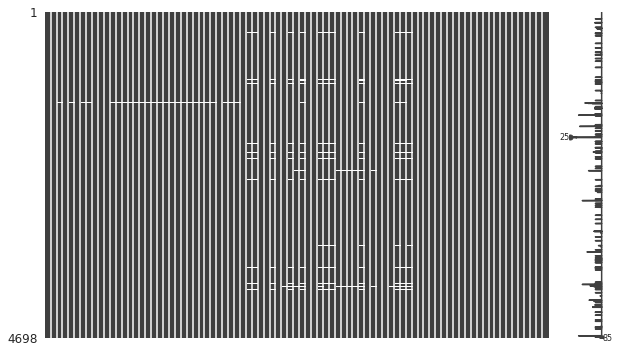

In [0]:
msno.matrix(df, figsize=(10, 6), fontsize=10);

Remove NaN values from dataset

In [0]:
number_before_removing = df.shape[0]
print('Number of rows before removing: ' + str(number_before_removing))

df.dropna(inplace=True)

number_after_removing = df.shape[0]
print('Number of rows after removing: ' + str(number_after_removing))
print(str(number_before_removing - number_after_removing) + ' rows were removed as NaN values')

Number of rows before removing: 4698
Number of rows after removing: 4524
174 rows were removed as NaN values


In [0]:
non_numeric_cols = ['ticker', 'date',	'sector']

numeric_df = df.drop(non_numeric_cols, axis=1).astype(np.float64)
numeric_df['sector'] = df['sector']

In [0]:
final_df = numeric_df.copy()
final_df

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,next year upside,sector
1,3.276500e+10,0.035000,1.668200e+10,1.608300e+10,1.821000e+09,7.602000e+09,9.423000e+09,7.207000e+09,350000000.0,7.000000e+09,1.637000e+09,0.0,0.0,5.349000e+09,0.0,5.349000e+09,9.09,8.89,588500000.0,602000000.0,5.303987,0.490859,0.265375,0.219960,0.163253,0.148390,8.695000e+09,7.207000e+09,5.349000e+09,0.213643,0.163253,2.853000e+09,3.800000e+08,3.233000e+09,5.020000e+09,4.366000e+09,1.370900e+10,8.738000e+09,1.270800e+10,0.0,...,2.266000e+09,1.211000e+09,7.244000e+09,1.341100e+10,1.462200e+10,0.0,243000000.0,0.0,1.642100e+10,2.670400e+10,0.0,4.063600e+10,9.796000e+09,3.800000e+08,1.176900e+10,0.0,3.039000e+09,1.488000e+09,302000000.0,6.439000e+09,1.577000e+09,1.300000e+07,-6.698000e+09,2.220000e+08,-7.500000e+08,-4.870000e+09,-3.193000e+09,-6.701000e+09,-160000000.0,-200000000.0,4.862000e+09,0.0,199.27,588500000.0,1.172704e+11,2.853000e+09,1.462200e+10,1.290394e+11,-0.184473,Industrials
2,3.165700e+10,0.051413,1.600100e+10,1.565600e+10,1.850000e+09,6.572000e+09,8.422000e+09,7.820000e+09,322000000.0,7.548000e+09,2.679000e+09,0.0,0.0,4.858000e+09,0.0,4.858000e+09,8.13,7.93,597500000.0,612700000.0,4.574833,0.494551,0.295796,0.247023,0.153457,0.153742,9.364000e+09,7.820000e+09,4.858000e+09,0.238431,0.153457,3.053000e+09,1.076000e+09,4.129000e+09,4.911000e+09,4.034000e+09,1.427700e+10,8.866000e+09,1.344900e+10,0.0,...,1.945000e+09,1.853000e+09,7.687000e+09,1.209600e+10,1.394900e+10,0.0,310000000.0,0.0,1.505800e+10,2.642400e+10,0.0,3.911500e+10,1.156300e+10,1.076000e+09,1.089600e+10,0.0,3.679000e+09,1.544000e+09,324000000.0,6.240000e+09,1.373000e+09,-2.023000e+09,-4.220000e+09,-3.086000e+09,-1.540000e+09,-2.068000e+09,-2.803000e+09,-2.655000e+09,156000000.0,655000000.0,4.867000e+09,0.0,251.54,597500000.0,1.502952e+11,3.053000e+09,1.394900e+10,1.611912e+11,-0.207800,Industrials
3,3.010900e+10,-0.005450,1.504000e+10,1.506900e+10,1.735000e+09,6.111000e+09,8.045000e+09,7.223000e+09,199000000.0,7.053000e+09,1.995000e+09,0.0,0.0,5.050000e+09,0.0,5.050000e+09,8.35,8.16,604700000.0,618700000.0,4.328431,0.500482,0.288851,0.239895,0.167724,0.174101,8.697000e+09,7.223000e+09,5.050000e+09,0.234249,0.167724,2.398000e+09,2.800000e+08,2.678000e+09,4.392000e+09,3.385000e+09,1.172600e+10,8.516000e+09,1.148600e+10,17000000.0,...,1.798000e+09,9.720000e+08,6.219000e+09,1.067800e+10,1.165000e+10,0.0,299000000.0,0.0,1.232600e+10,2.260800e+10,0.0,3.790700e+10,1.029800e+10,2.970000e+08,9.252000e+09,0.0,4.063000e+09,1.474000e+09,298000000

In [0]:
x = final_df.drop('next year upside', axis=1).copy()
y = final_df['next year upside'].copy()

### Pipeline 

(cross-validation, normalization)

In [0]:
numeric_cols = list(x.select_dtypes(np.number))
numeric_transformer = Pipeline([
  ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
  ('scale', MinMaxScaler()),
  ('normalize', QuantileTransformer(output_distribution='normal')) # normalize data
])

str_cols = list(x.select_dtypes(np.object))
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, str_cols)
    ])

### Train/test split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=RANDOM_SEED)

## Baseline

In [0]:
class Evaluator:

  total_scores = dict()
  models = dict()

  def __init__(self, metrics):
    self.metrics = metrics

  def set_metrics(self, metrics):
    self.metrics = metrics

  def get_model(self, name):
    return self.models[name]

  def test_model(self, name, model, x, y, folds=5, preprocess=True):
    self.models[name] = model
    steps = [('preprocessor', preprocessor), ('model', model)]
    if (not preprocess):
      print('skip preprocessing...')
      steps = [('model', model)]
    clf = Pipeline(steps=steps)

    model_scores = cross_validate(clf, x, y, scoring=self.metrics, cv=folds)
    self.total_scores[name] = self._process_scores(model_scores)
    self.print_scores(name)

  def _process_scores(self, model_scores):
    model_scores.pop('fit_time', None)
    model_scores.pop('score_time', None)
    mean_scores = dict()
    for k, v in model_scores.items():
      mean_scores[k] = abs(np.mean(v))
    return list(mean_scores.values())

  def print_scores(self, name='none'):
    if type(self.metrics) is dict:
      accuracy = list([['model'] + list(self.metrics.keys())])
    elif type(self.metrics) is list:
      accuracy = list([['model'] + self.metrics])

    if (name != 'none'):
      accuracy.append([name] + self.total_scores[name])
    else:
      for k, v in self.total_scores.items():
        accuracy.append([k] + v)

    print('\nAverage cross-validation metrics')
    print(tabulate(accuracy, tablefmt='grid'))

### Metrics

In [0]:
metrics = {
    'neg_mean_squared_error': 'neg_mean_squared_error', 
    'neg_mean_absolute_error': 'neg_mean_absolute_error', 
    'r2': 'r2'
}

In [0]:
evaluator = Evaluator(metrics)

model = LinearRegression()
evaluator.test_model('Baseline', model, x_train, y_train)


Average cross-validation metrics
+----------+------------------------+-------------------------+-------------------+
| model    | neg_mean_squared_error | neg_mean_absolute_error | r2                |
+----------+------------------------+-------------------------+-------------------+
| Baseline | 4844.997116671437      | 12.825181360327957      | 4929.005080446743 |
+----------+------------------------+-------------------------+-------------------+


In [0]:
evaluator = Evaluator(metrics)

model = Ridge()
evaluator.test_model('Ridge', model, x_train, y_train)


Average cross-validation metrics
+-------+------------------------+-------------------------+-------------------+
| model | neg_mean_squared_error | neg_mean_absolute_error | r2                |
+-------+------------------------+-------------------------+-------------------+
| Ridge | 4837.757549844568      | 12.737896871899867      | 4844.785923496229 |
+-------+------------------------+-------------------------+-------------------+


## Feature engineering
Basic transformations (nonlinear)

### Nonlinear transformations

### Polynomial transformations

Polynomial transformation with 2 degrees

In [0]:
x_train_numeric = x_train.drop('sector', axis=1)
poly = PolynomialFeatures(2)
x_train_numeric_poly_2 = poly.fit_transform(x_train_numeric)
# x_train_numeric_poly_2 = np.column_stack((x_train_numeric_poly_2, x_train['sector']))

In [0]:
x_train_numeric_poly_2 = pd.DataFrame(x_train_numeric_poly_2)
x_train_numeric_poly_2['sector'] = x_train['sector']
x_train_numeric_poly_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399,3400,3401,3402,sector
0,1.0,9.611400e+10,0.000000,8.208800e+10,1.402600e+10,3.331000e+09,3.525000e+09,6.856000e+09,7.443000e+09,275000000.0,7.155000e+09,1.979000e+09,0.0,0.0,5.176000e+09,0.0,5.176000e+09,7.52,7.44,686900000.0,688000000.0,3.619186,0.145931,0.096510,0.077439,0.053853,0.071925,9.276000e+09,7.443000e+09,5.176000e+09,0.074443,0.053853,1.130200e+10,7.500000e+08,1.205200e+10,8.713000e+09,4.725700e+10,6.823400e+10,1.207600e+10,7.783000e+09,...,-4.871162e+18,-4.294484e+18,-3.498828e+19,4.778957e+19,0.0,8.304587e+11,4.748540e+18,5.704421e+20,7.813073e+19,6.888113e+19,5.611925e+20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14431.2169,8.251730e+10,9.912803e+12,1.357709e+12,1.196975e+12,9.752069e+12,4.718316e+17,5.668113e+19,7.763344e+18,6.844272e+18,5.576206e+19,6.809104e+21,9.326105e+20,8.222023e+20,6.698696e+21,1.277352e+20,1.126131e+20,9.174884e+20,9.928130e+19,8.088705e+20,6.590078e+21,NaN
1,1.0,4.238094e+10,0.077751,3.470436e+10,7.676577e+09,0.000000e+00,0.000000e+00,5.785945e+09,1.890632e+09,113396000.0,1.784002e+09,6.624170e+08,0.0,0.0,1.121585e+09,0.0,1.121585e+09,1.91,1.90,587726343.0,588991441.0,1.057518,0.181133,0.054448,0.044610,0.026464,0.014622,2.307575e+09,1.890632e+09,1.121585e+09,0.042094,0.026464,6.888670e+08,0.000000e+00,6.888670e+08,0.000000e+00,2.178830e+09,6.084808e+09,3.883750e+09,1.779182e+09,...,3.382475e+16,1.482064e+17,9.613798e+17,3.840021e+17,0.0,1.818758e+10,3.642017e+17,1.068932e+19,4.268764e+17,1.870401e+18,1.213284e+19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861.4225,1.724977e+10,5.062807e+11,2.021825e+10,8.858822e+10,5.746507e+11,3.454223e+17,1.013814e+19,4.048653e+17,1.773957e+18,1.150723e+19,2.975545e+20,1.188280e+19,5.206563e+19,3.377373e+20,4.745377e+17,2.079233e+18,1.348749e+19,9.110364e+18,5.909676e+19,3.833466e+20,Industrials
2,1.0,1.959800e+09,0.000000,7.588000e+08,1.201000e+09,0.000000e+00,5.645000e+08,5.645000e+08,4.710000e+08,55100000.0,4.082000e+08,1.680000e+08,0.0,0.0,2.329000e+08,0.0,2.329000e+08,1.91,1.88,121900000.0,123700000.0,0.631366,0.612818,0.324472,0.240331,0.118839,0.170272,6.359000e+08,4.710000e+08,2.329000e+08,0.208287,0.118839,1.468000e+08,0.000000e+00,1.468000e+08,3.170000e+08,0.000000e+00,5.297000e+08,2.837000e+08,3.278100e+09,...,1.218440e+15,1.436481e+16,7.261821e+16,1.113557e+17,0.0,1.961489e+10,4.067803e+16,2.391055e+18,4.898716e+16,5.775346e+17,2.919602e+18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3455.0884,7.165282e+09,4.211753e+11,8.628904e+09,1.017305e+11,5.142769e+11,1.485961e+16,8.734479e+17,1.789492e+16,2.109723e+17,1.066525e+18,5.134127e+19,1.051863e+18,1.240095e+19,6.269036e+19,2.155024e+16,2.540668e+17,1.284380e+18,2.995322e+18,1.514221e+19,7.654819e+19,Industrials
3,1.0,1.023500e+07,2.340405,0.000000e+00,1.023500e+07,0.000000e+00,4.866900e+07,1.871040e+08,6.050200e+08,40734000.0,4.971890e+08,-1.956800e+07,0.0,0.0,4.822610e+08,0.0,4.822610e+08,4.95,4.94,97458000.0,97688000.0,0.000000,1.000000,91.423742,59.112848,47.118808,86.822179,9.357220e+08,6.050200e+08,4.822610e+08,48.577333,47.118808,1.124460e+08,5.310000e+05,1.129770e+08,1.585750e+08,9.108000e+06,3.586010e+08,7.343617e+09,0.000000e+00,...,-1.747555e+17,-2.295986e+18,-2.124636e+19,7.896544e+17,0.0,1.122067e+11,8.660362e+16,1.093544e+19,9.992233e+16,1.312807e+18,1.214832e+19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15944.1129,1.230602e+10,1.553881e+12,1.419856e+10,1.865446e+11,1.726227e+12,9.498062e+15,1.199320e+18,1.095876e+16,1.439793e+17,1.332341e+18,1.514382e+20,1.383763e+18,1.818026e+19,1.682347e+20,1.264410e+16,1.661218e+17,1.537241e+18,2.182554e+18,2.019670e+19,1.868941e+20,Industrials
4,1.0,4.501223e+09,0.095650,1.503835e+09,2.997388e+09,0.000000e+00,2.502140e+08,7.651770e+08,7.635890e+08,0.0,7.698670e+08,2.942650e+08,0.0,0.0,4.756020e+08,0.0,4.75

In [0]:
numeric_cols = list(x_train_numeric_poly_2.select_dtypes(np.number))
numeric_transformer = Pipeline([
  ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
  ('scale', MinMaxScaler()),
  ('normalize', QuantileTransformer(output_distribution='normal')) # normalize data
])

str_cols = list(x_train_numeric_poly_2.select_dtypes(np.object))
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, str_cols)
    ])

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
])
x_train_transformed = pipeline.fit_transform(x_train_numeric_poly_2)

In [0]:
evaluator = Evaluator(metrics)

model = LinearRegression()
# evaluator.test_model('Poly 2', model, x_train_numeric_poly_2, y_train)
evaluator.test_model('Poly 2', model, x_train_transformed, y_train.to_numpy(), preprocess=False)

skip preprocessing...

Average cross-validation metrics
+--------+------------------------+-------------------------+--------------------+
| model  | neg_mean_squared_error | neg_mean_absolute_error | r2                 |
+--------+------------------------+-------------------------+--------------------+
| Poly 2 | 327787421647.47815     | 97106.84327091937       | 3785070401974.3555 |
+--------+------------------------+-------------------------+--------------------+


In [0]:
evaluator = Evaluator(metrics)

model = Ridge()
# evaluator.test_model('Poly 2', model, x_train_numeric_poly_2, y_train)
evaluator.test_model('Ridge Poly 2', model, x_train_transformed, y_train.to_numpy(), preprocess=False)

skip preprocessing...

Average cross-validation metrics
+--------------+------------------------+-------------------------+-----------------+
| model        | neg_mean_squared_error | neg_mean_absolute_error | r2              |
+--------------+------------------------+-------------------------+-----------------+
| Ridge Poly 2 | 19217.796082425135     | 54.29244423025589       | 167496.53721436 |
+--------------+------------------------+-------------------------+-----------------+


In [0]:
evaluator = Evaluator(metrics)

model = SVR()
# evaluator.test_model('Poly 2', model, x_train_numeric_poly_2, y_train)
evaluator.test_model('SVR Poly 2', model, x_train_transformed, y_train.to_numpy(), preprocess=False)

skip preprocessing...

Average cross-validation metrics
+------------+------------------------+-------------------------+----------------------+
| model      | neg_mean_squared_error | neg_mean_absolute_error | r2                   |
+------------+------------------------+-------------------------+----------------------+
| SVR Poly 2 | 4416.019790733683      | 1.3107907397834038      | 0.022940914294061733 |
+------------+------------------------+-------------------------+----------------------+


In [0]:
evaluator = Evaluator(metrics)

model = KernelRidge()
# evaluator.test_model('Poly 2', model, x_train_numeric_poly_2, y_train)
evaluator.test_model('KernelRidge Poly 2', model, x_train_transformed, y_train.to_numpy(), preprocess=False)

skip preprocessing...

Average cross-validation metrics
+--------------------+------------------------+-------------------------+--------------------+
| model              | neg_mean_squared_error | neg_mean_absolute_error | r2                 |
+--------------------+------------------------+-------------------------+--------------------+
| KernelRidge Poly 2 | 19198.50886235065      | 54.28998101114102       | 167282.61888204335 |
+--------------------+------------------------+-------------------------+--------------------+


In [0]:
evaluator.print_scores()


Average cross-validation metrics
+--------------------+------------------------+-------------------------+----------------------+
| model              | neg_mean_squared_error | neg_mean_absolute_error | r2                   |
+--------------------+------------------------+-------------------------+----------------------+
| Baseline           | 4844.997116671437      | 12.825181360327957      | 4929.005080446743    |
+--------------------+------------------------+-------------------------+----------------------+
| Ridge              | 4837.757549844568      | 12.737896871899867      | 4844.785923496229    |
+--------------------+------------------------+-------------------------+----------------------+
| Poly 2             | 327787421647.47815     | 97106.84327091937       | 3785070401974.3555   |
+--------------------+------------------------+-------------------------+----------------------+
| SVR                | 4416.019790733683      | 1.3107907397834038      | 0.02294091429406173

# Test

**Train model**

In [0]:
SVR_reg = SVR().fit(x_train_transformed, y_train.to_numpy())

In [0]:
KernelRidge_reg = KernelRidge().fit(x_train_transformed, y_train.to_numpy())

**Transform data**

In [0]:
x_test_numeric = x_test.drop('sector', axis=1)
poly = PolynomialFeatures(2)
x_test_numeric_poly_2 = poly.fit_transform(x_test_numeric)
# x_train_numeric_poly_2 = np.column_stack((x_train_numeric_poly_2, x_train['sector']))

In [0]:
x_test_numeric_poly_2 = pd.DataFrame(x_test_numeric_poly_2)
x_test_numeric_poly_2['sector'] = x_test['sector']
x_test_numeric_poly_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399,3400,3401,3402,sector
0,1.0,1.297300e+10,-0.048000,8.434000e+09,4.539000e+09,0.0,0.000000e+00,2.103000e+09,2.436000e+09,978000000.0,1.809000e+09,9.370000e+08,-16000000.0,0.0,8.720000e+08,0.0,8.720000e+08,2.87,2.85,3.048354e+08,3.040000e+08,2.200000,0.349900,0.352000,0.214800,0.067000,0.020200,4.563000e+09,2.787000e+09,8.560000e+08,0.139400,0.067200,8.740000e+08,0.000000e+00,8.740000e+08,1.397000e+09,6.470000e+08,3.320000e+09,1.916400e+10,5.575000e+09,...,2.875460e+17,4.909667e+18,8.996808e+18,6.864400e+16,-2.599564e+08,1.142844e+10,7.986688e+16,3.483793e+18,2.289880e+17,3.909826e+18,7.164631e+18,0.984461,-43.279764,-3.024577e+08,-1.319320e+10,-867182800.0,-1.480660e+10,-2.713262e+10,1902.7044,1.329692e+10,5.800117e+11,3.812388e+10,6.509413e+11,1.192829e+12,9.292463e+16,4.053372e+18,2.664261e+17,4.549059e+18,8.336005e+18,1.768081e+20,1.162151e+19,1.984299e+20,3.636165e+20,7.638760e+17,1.304270e+19,2.390033e+19,2.226959e+20,4.080832e+20,7.477994e+20,NaN
1,1.0,9.656800e+09,0.083232,4.348500e+09,5.308300e+09,0.0,4.432800e+09,4.432800e+09,8.917000e+08,120800000.0,7.756000e+08,3.100000e+07,0.0,0.0,7.464000e+08,0.0,7.464000e+08,9.75,9.65,7.650000e+07,7.730000e+07,0.000000,0.549696,0.127009,0.092339,0.077293,0.048981,1.226500e+09,8.917000e+08,7.464000e+08,0.080316,0.077293,4.520000e+08,1.947000e+08,4.520000e+08,7.778000e+08,1.732400e+09,3.238600e+09,9.845000e+08,4.376000e+09,...,-1.893880e+16,-1.181329e+17,-4.557251e+17,2.237290e+17,0.000000e+00,5.261179e+10,3.618450e+16,4.024802e+18,2.137960e+17,1.333576e+18,5.144582e+18,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,12372.1129,8.509095e+09,9.464666e+11,5.027596e+10,3.136019e+11,1.209793e+12,5.852250e+15,6.509458e+17,3.457800e+16,2.156841e+17,8.320519e+17,7.240470e+19,3.846111e+18,2.399054e+19,9.254913e+19,2.043040e+17,1.274369e+18,4.916176e+18,7.949016e+18,3.066519e+19,1.182981e+20,NaN
2,1.0,7.709000e+09,0.025815,4.719000e+09,2.990000e+09,0.0,1.750000e+09,1.598000e+09,1.165000e+09,153000000.0,1.030000e+09,2.410000e+08,0.0,0.0,7.720000e+08,0.0,7.720000e+08,5.63,5.50,1.370000e+08,1.400000e+08,1.764286,0.387858,0.186146,0.151122,0.100143,0.119730,1.435000e+09,1.165000e+09,7.720000e+08,0.133610,0.100143,1.370000e+08,0.000000e+00,1.370000e+08,9.240000e+08,9.500000e+07,1.306000e+09,1.145000e+09,7.454000e+09,...,-3.041400e+16,-8.400480e+17,-4.068798e+18,8.519290e+17,0.000000e+00,9.890868e+10,1.264510e+17,1.355049e+19,1.264510e+17,3.492632e+18,1.691667e+19,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,11483.2656,1.468092e+10,1.573207e+12,1.468092e+10,4.054934e+11,1.964020e+12,1.876900e+16,2.011286e+18,1.876900e+16,5.184080e+17,2.510925e+18,2.155294e+20,2.011286e+18,5.555260e+19,2.690707e+20,1.876900e+16,5.184080e+17,2.510925e+18,1.431866e+19,6.935285e+19,3.359127e+20,NaN
3,1.0,5.407000e+09,-0.056699,3.490000e+09,1.917000e+09,0.0,0.000000e+00,0.000000e+00,2.510000e+08,53000000.0,2.510000e+08,-3.600000e+07,0.0,0.0,2.870000e+08,0.0,2.870000e+08,1.76,1.75,1.632000e+08,1.645000e+08,2.042553,0.354540,0.058073,0.046421,0.053079,0.214722,3.140000e+08,2.510000e+08,2.870000e+08,0.046421,0.053079,7.840000e+08,1.673200e+10,1.751600e+10,1.644000e+09,0.000000e+00,1.916000e+10,1.950000e+08,0.000000e+00,...,9.956800e+16,1.059180e+17,1.668400e+18,1.347921e+18,0.000000e+00,9.310059e+10,1.894752e+17,1.519402e+19,9.102240e+17,9.682740e+17,1.525207e+19,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,6430.4361,1.308701e+10,1.049447e+12,6.286896e+10,6.687846e+10,1.053457e+12,2.663424e+16,2.135800e+18,1.279488e+17,1.361088e+17,2.143960e+18,1.712698e+20,1.026021e+19,1.091456e+19,1.719241e+20,6.146560e+17,6.538560e+17,1.029941e+19,6.955560e+17,1.0

In [0]:
numeric_cols = list(x_test_numeric_poly_2.select_dtypes(np.number))
numeric_transformer = Pipeline([
  ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
  ('scale', MinMaxScaler()),
  ('normalize', QuantileTransformer(output_distribution='normal')) # normalize data
])

str_cols = list(x_test_numeric_poly_2.select_dtypes(np.object))
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, str_cols)
    ])

In [0]:
pipeline = Pipeline(steps=[
                      ('preprocessor', preprocessor)
])
x_test_transformed = pipeline.fit_transform(x_test_numeric_poly_2)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (905). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


**Tests**

In [0]:
x_test.head(3)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Total assets,Payables,Short-term debt,Total current liabilities,Long-term debt,Total debt,Deferred revenue,Tax Liabilities,Deposit Liabilities,Total non-current liabilities,Total liabilities,Other comprehensive income,Retained earnings (deficit),Total shareholders equity,Investments,Net Debt,Other Assets,Other Liabilities,Depreciation & Amortization,Stock-based compensation,Operating Cash Flow,Capital Expenditure,Acquisitions and disposals,Investment purchases and sales,Investing Cash flow,Issuance (repayment) of debt,Issuance (buybacks) of shares,Dividend payments,Financing Cash Flow,Effect of forex changes on cash,Net cash flow / Change in cash,Free Cash Flow,Net Cash/Marketcap,Stock Price,Number of Shares,Market Capitalization,- Cash & Cash Equivalents,+ Total Debt,Enterprise Value,sector
2022,1.297300e+10,-0.048000,8.434000e+09,4.539000e+09,0.0,0.000000e+00,2.103000e+09,2.436000e+09,978000000.0,1.809000e+09,937000000.0,-16000000.0,0.0,872000000.0,0.0,872000000.0,2.87,2.85,304835407.0,304000000.0,2.200000,0.349900,0.352000,0.214800,0.067000,0.020200,4.563000e+09,2.787000e+09,856000000.0,0.139400,0.067200,874000000.0,0.0,874000000.0,1.397000e+09,6.470000e+08,3.320000e+09,1.916400e+10,5.575000e+09,2.402000e+09,...,3.430400e+10,8.290000e+08,2.915000e+09,5.188000e+09,1.200800e+10,1.492300e+10,0.0,2.782000e+09,0.0,2.055900e+10,2.574700e+10,-1.415000e+09,4.495000e+09,8.559000e+09,2.402000e+09,1.404900e+10,402000000.0,1.444000e+09,1.776000e+09,20000000.0,2.465000e+09,-2.203000e+09,0.0,-17000000.0,-2.185000e+09,776000000.0,0.0,-670000000.0,49000000.0,0.0,329000000.0,262000000.0,-0.9922,43.62,304835407.0,1.329692e+10,874000000.0,1.492300e+10,2.734592e+10,Utilities
4106,9.656800e+09,0.083232,4.348500e+09,5.308300e+09,0.0,4.432800e+09,4.432800e+09,8.917000e+08,120800000.0,7.756000e+08,31000000.0,0.0,0.0,746400000.0,0.0,746400000.0,9.75,9.65,76500000.0,77300000.0,0.000000,0.549696,0.127009,0.092339,0.077293,0.048981,1.226500e+09,8.917000e+08,746400000.0,0.080316,0.077293,452000000.0,194700000.0,452000000.0,7.778000e+08,1.732400e+09,3.238600e+09,9.845000e+08,4.376000e+09,0.000000e+00,...,1.186370e+10,9.242000e+08,0.000000e+00,1.893900e+09,2.819400e+09,2.819400e+09,65300000.0,0.000000e+00,0.0,4.707000e+09,6.035900e+09,1.900200e+09,4.350100e+09,5.827800e+09,1.947000e+08,2.367400e+09,0.0,-5.650000e+08,3.348000e+08,56200000.0,8.525000e+08,3.795000e+08,-15900000.0,-325200000.0,-4.159000e+08,-0.0,-325200000.0,-0.0,-478500000.0,-20500000.0,-41900000.0,473000000.0,0.0000,111.23,76500000.0,8.509095e+09,452000000.0,2.819400e+09,1.087650e+10,Consumer Cyclical
4147,7.709000e+09,0.025815,4.719000e+09,2.990000e+09,0.0,1.750000e+09,1.598000e+09,1.165000e+09,153000000.0,1.030000e+09,241000000.0,0.0,0.0,772000000.0,0.0,772000000.0,5.63,5.50,137000000.0,140000000.0,1.764286,0.387858,0.186146,0.151122,0.100143,0.119730,1.435000e+09,1.165000e+09,772000000.0,0.133610,0.100143,137000000.0,0.0,137000000.0,9.240000e+08,9.500000e+07,1.306000e+09,1.145000e+09,7.454000e+09,0.000000e+00,...,1.050300e+10,1.021000e+09,3.600000e+07,1.057000e+09,3.748000e+09,3.784000e+09,0.0,0.000000e+00,0.0,4.411000e+09,5.582000e+09,0.000000e+00,7.138000e+09,4.921000e+09,0.000000e+00,3.647000e+09,0.0,1.140000e+08,2.700000e+08,79000000.0,1.175000e+09,2.520000

In [0]:
y_test[752:759]

2275    0.231715
4666   -0.229752
92      0.366292
2405    0.611770
518    -0.122726
2162   -0.726353
41      0.250984
Name: next year upside, dtype: float64

In [0]:
list(SVR_reg.predict(x_train_transformed[752:759,:]))

[0.2934011988419264,
 0.14824378597128915,
 -0.0430488672168273,
 0.02170178575326659,
 0.2923585577253235,
 0.21749355928299915,
 0.12816147904567068]